In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/Users/ShantanuOjha/Downloads/dogs-vs-cats"))

['model2nd.h5', '.DS_Store', 'sampleSubmission.csv', 'with saved weights.ipynb', 'Untitled.ipynb', 'test1', '10th sep-Copy1.ipynb', 'Desktop', '10th sep.ipynb', 'test1.zip', 'train', 'model.h5', 'model1st.h5', '.ipynb_checkpoints', 'train.zip']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("/Users/ShantanuOjha/Downloads/dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(10)


,filename,category
0,dog.8011.jpg,1
1,"cat5,471.jpg",0
2,dog.7322.jpg,1
3,"cat4,662.jpg",0
4,"cat7,979.jpg",0
5,"cat1,055.jpg",0
6,dog.1753.jpg,1
7,"cat3,385.jpg",0
8,"cat2,196.jpg",0
9,dog.5535.jpg,1


<AxesSubplot:>

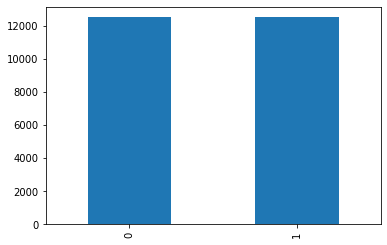

In [5]:
df['category'].value_counts().plot.bar()

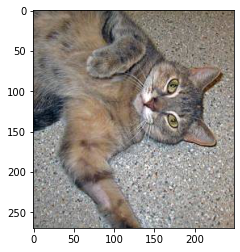

In [6]:
sample = random.choice(df.filename)
image = load_img("/Users/ShantanuOjha/Downloads/dogs-vs-cats/train/"+sample)
plt.imshow(image)


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
earlystop = EarlyStopping(patience=10)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25001 entries, 0 to 25000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25001 non-null  object
 1   category  25001 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

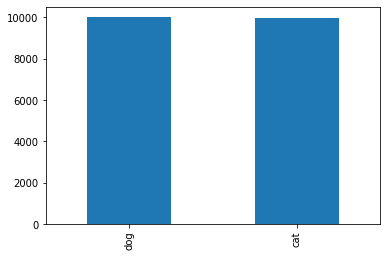

In [17]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

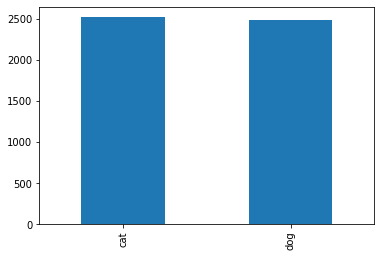

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/Users/ShantanuOjha/Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19999 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/Users/ShantanuOjha/Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5001 validated image filenames belonging to 2 classes.


In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/Users/ShantanuOjha/Downloads/dogs-vs-cats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


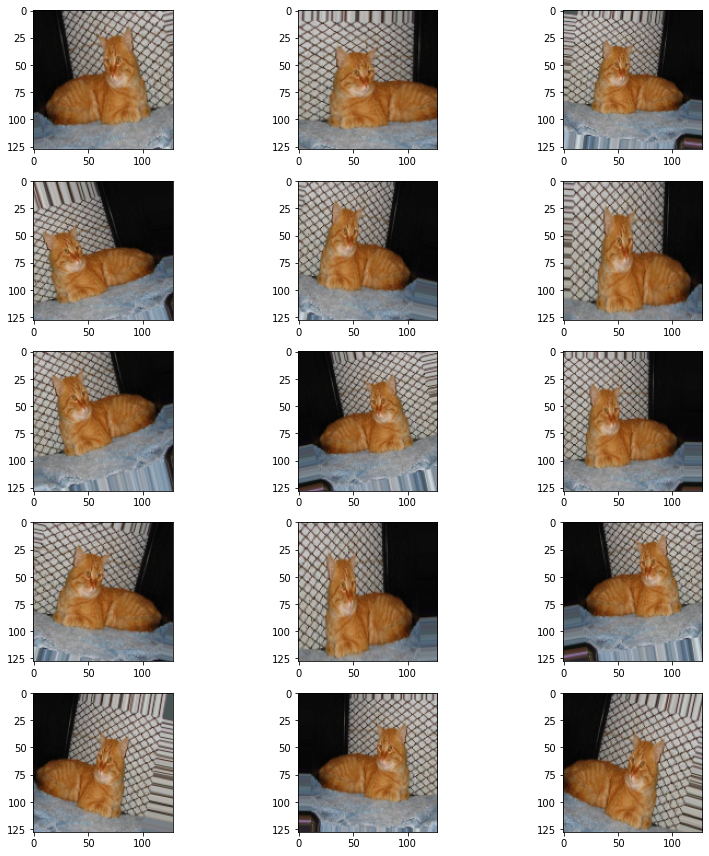

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [24]:
epochs=3 if FAST_RUN else 15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks 
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
1333/1333 [==============================] - 474s 356ms/step - loss: 0.7369 - accuracy: 0.6366 - val_loss: 0.5573 - val_accuracy: 0.7227
Epoch 2/15
1333/1333 [==============================] - 484s 363ms/step - loss: 0.5534 - accuracy: 0.7260 - val_loss: 0.5087 - val_accuracy: 0.7568
Epoch 3/15
1333/1333 [==============================] - 452s 339ms/step - loss: 0.5044 - accuracy: 0.7600 - val_loss: 0.5302 - val_accuracy: 0.7536
Epoch 4/15
1333/1333 [==============================] - 459s 344ms/step - loss: 0.4766 - accuracy: 0.7789 - val_loss: 0.4059 - val_accuracy: 0.8210
Epoch 5/15
1333/1333 [==============================] - 458s 344ms/step - loss: 0.4419 - accuracy: 0.7989 - val_loss: 0.6858 - val_accuracy: 0.6104
Epoch 6/15
1333/1333 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8058
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1

In [25]:
model.save_weights("binarymodel.h5")


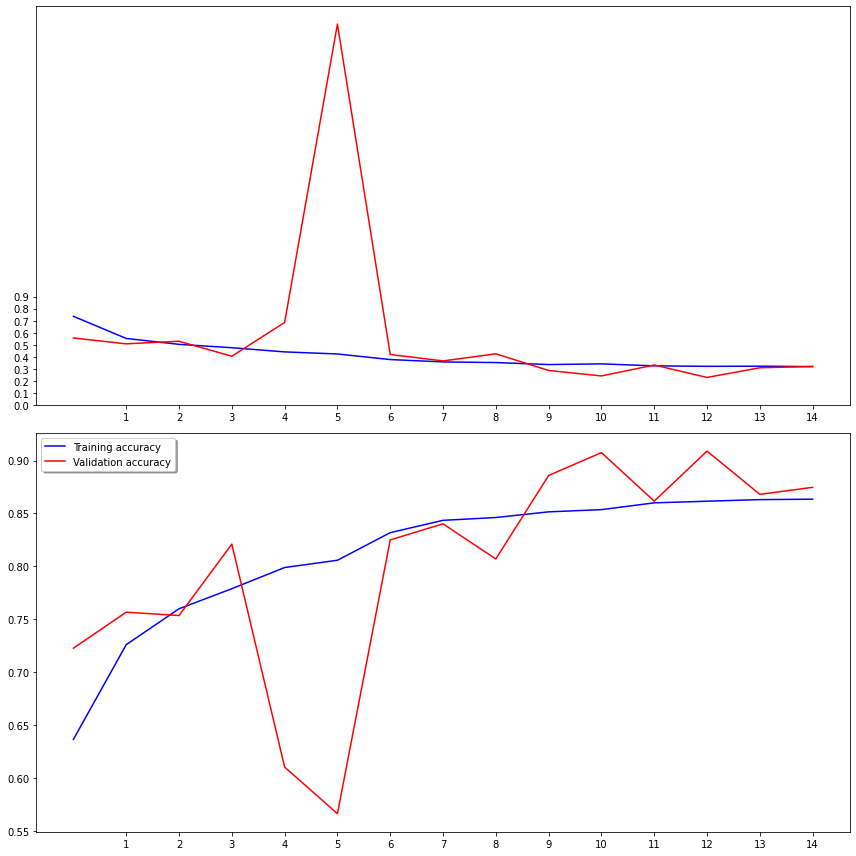

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [27]:
test_filenames = os.listdir("/Users/ShantanuOjha/Downloads/dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/Users/ShantanuOjha/Downloads/dogs-vs-cats/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [37]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [38]:
test_df['category'] = np.argmax(predict, axis=-1)

In [39]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [54]:
#test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<AxesSubplot:>

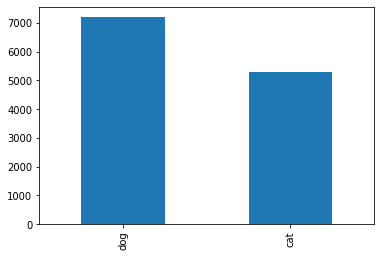

In [40]:
test_df['category'].value_counts().plot.bar()

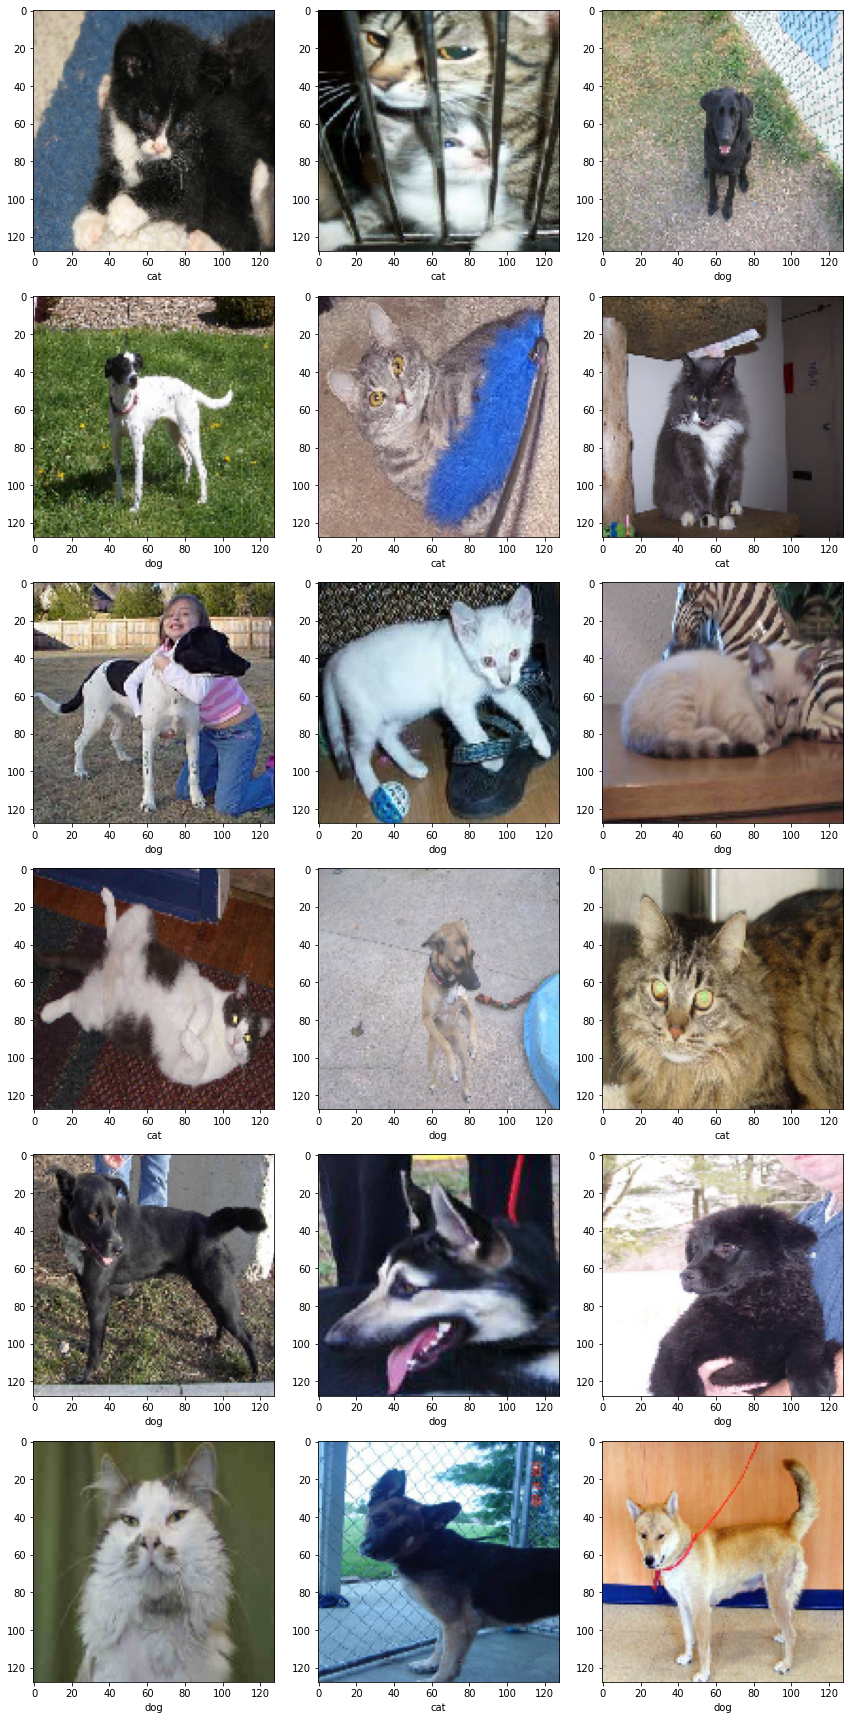

In [41]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
output=1
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/Users/ShantanuOjha/Downloads/dogs-vs-cats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, output)
    output=output+1
    plt.imshow(img)
    plt.xlabel( "{}".format(category)  )
plt.tight_layout()
plt.show()

In [43]:
#model.summary()

from keras.preprocessing.image import load_img


In [68]:
img = load_img('/Users/ShantanuOjha/Downloads/q.jpg',target_size=(128,128,3))

In [73]:
img = np.reshape(img,[1,128,128,3])


In [88]:
result=model.predict(img)

In [90]:
result.size


2

In [91]:
result=np.argmax(result, axis=-1)

In [92]:
result.size

1

In [93]:
result

array([1])

Text(0.5, 0, 'dog')

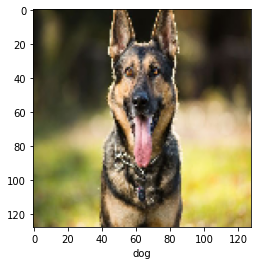

In [112]:
plt.subplot(1,1,1)
plt.imshow(load_img('/Users/ShantanuOjha/Downloads/q.jpg',target_size=(128,128)))
if result[0]==1:
    cord="dog"
else:
    cord="cat"
plt.xlabel("{}".format(cord))

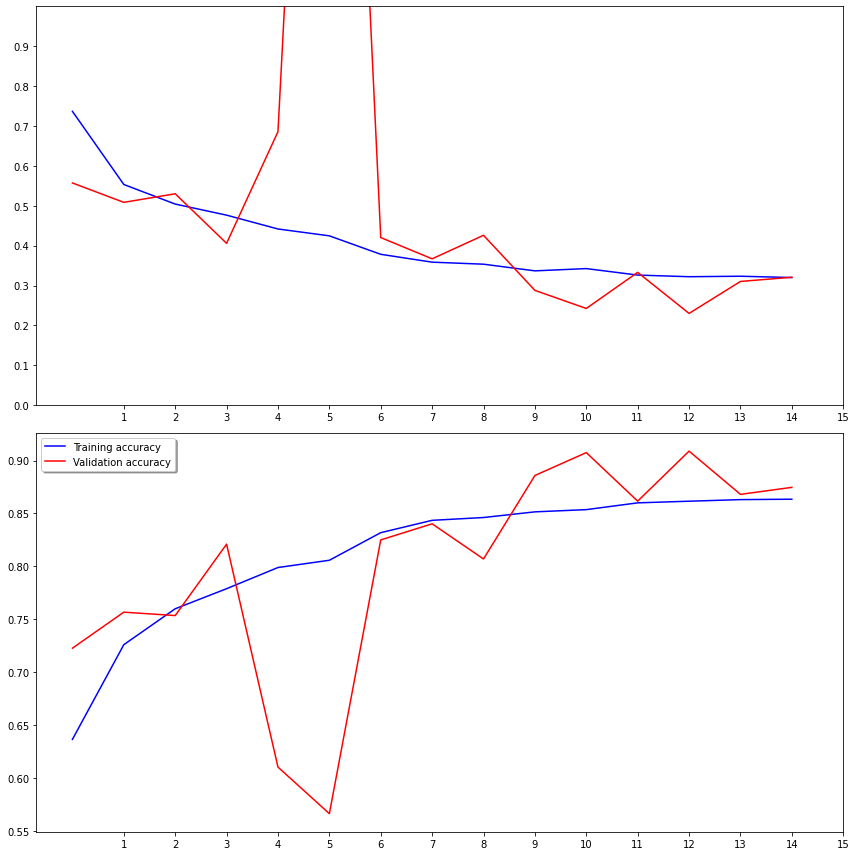

In [132]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs+1, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.axis(ymin=0,ymax=1)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs+1, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [134]:
type(history.history)

dict

In [135]:
np.save('history.npy', history.history) 

In [137]:
read_dictionary = np.load('history.npy',allow_pickle='TRUE').item()

In [139]:
type(read_dictionary)

dict